<a href="https://colab.research.google.com/github/abhishek2602/Projects/blob/master/Airways_Sentiment_Analysis_AbhishekKumar_Tech2Hire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Use Case - 1 (Airways Tweets Sentimental Analysis)
## Tech2Hire - Techolution
### Abhishek Kumar

### Loading the required Libraries and Packages

In this section we are going to focus on the most important part of the analysis. In general rule the tweet are composed by several strings that we have to clean before working correctly with the data. I have separated the importation of package into three parts. As usual Numpy and Pandas are part of our toolbox.

For the visualisation we use Seaborn, Matplotlib. In order to clean our data (text) and to do the sentiment analysis the most common library is NLTK. NLTK is a leading platform Python programs to work with human language data.

In [0]:
import numpy as np
import pandas as pd
import re
import warnings

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
nltk.download('wordnet')
nltk.download('vader_lexicon')

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

%matplotlib inline


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Loading the Dataset

This code snipit is for loading the data in Google Colab using PyDrive.

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 20.8MB/s 


In [0]:
link = "https://drive.google.com/open?id=1rO49I-W_xtsHgqNZQr1C0eAzZIxEzBUK"
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('AirWays_Sentiment_Analysis.csv')  
tweets = pd.read_csv('AirWays_Sentiment_Analysis.csv')

### Data Cleaning

In [0]:
# Deleting unwanted columns from the dataset

tweets = tweets.drop(columns = ['tweet_id', 'airline_sentiment_confidence', 'airline', 'name',
       'tweet_created', 'tweet_location', 'user_timezone', 'airline_sentiment',], axis = 1)

In [0]:
# Looking at one data point

tweets['text'][1]

"@VirginAmerica plus you've added commercials to the experience... tacky."

For the first step we are going to extract the username through the tweets (preceded by @ or by RT @). We keep this information in the column “tweetos”.

In [0]:
#Preprocessing del RT @blablabla:
tweets['tweetos'] = '' 

#add tweetos first part
for i in range(len(tweets['text'])):
    try:
        tweets['tweetos'][i] = tweets['text'].str.split(' ')[i][0]
    except AttributeError:    
        tweets['tweetos'][i] = 'other'

#Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(tweets['text'])):
    if tweets['tweetos'].str.contains('@')[i]  == False:
        tweets['tweetos'][i] = 'other'
        
# remove URLs, RTs, and twitter handles
for i in range(len(tweets['text'])):
    tweets['text'][i] = " ".join([word for word in tweets['text'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])


tweets['text'][1]

"plus you've added commercials to the experience... tacky."

We can see that the first step of the cleaning it well done ! The username and the URL are deleted correctly. Now we are going to delete certains punctuations, put the text in lower case and delete the double space with the function apply.

In [0]:
tweets['text'] = tweets['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
tweets['text'] = tweets['text'].apply(lambda x: re.sub('  ', ' ', x))
tweets['text'][1]

"plus you've added commercials to the experience tacky"

### Sentiment Analysis

Now, we are going to do an sentiment analysis. The objective is to class by type the tweets. We are going to distinguish 3 kinds of tweets according to their polarity score. We will have the Happy tweets, the neutral tweets, and the Sad tweets.

In [0]:
tweets['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in tweets['text']]       
vectorizer = TfidfVectorizer(max_df = 0.5, max_features = 10000, min_df = 10, stop_words = 'english', use_idf = True)
X = vectorizer.fit_transform(tweets['text_lem'].str.upper())
sid = SentimentIntensityAnalyzer()
tweets['sentiment_compound_polarity'] = tweets.text_lem.apply(lambda x: sid.polarity_scores(x)['compound'])
tweets['sentiment_neutral'] = tweets.text_lem.apply(lambda x: sid.polarity_scores(x)['neu'])
tweets['sentiment_negative'] = tweets.text_lem.apply(lambda x: sid.polarity_scores(x)['neg'])
tweets['sentiment_pos'] = tweets.text_lem.apply(lambda x: sid.polarity_scores(x)['pos'])
tweets['sentiment_type'] = ''
tweets.loc[tweets.sentiment_compound_polarity > 0,'sentiment_type'] = 'HAPPY'
tweets.loc[tweets.sentiment_compound_polarity == 0,'sentiment_type'] = 'NEUTRAL'
tweets.loc[tweets.sentiment_compound_polarity < 0,'sentiment_type'] = 'SAD'

In [0]:
tweets_sentiment.head()

sentiment_type
HAPPY      6392
NEUTRAL    3219
SAD        5029
Name: , dtype: int64

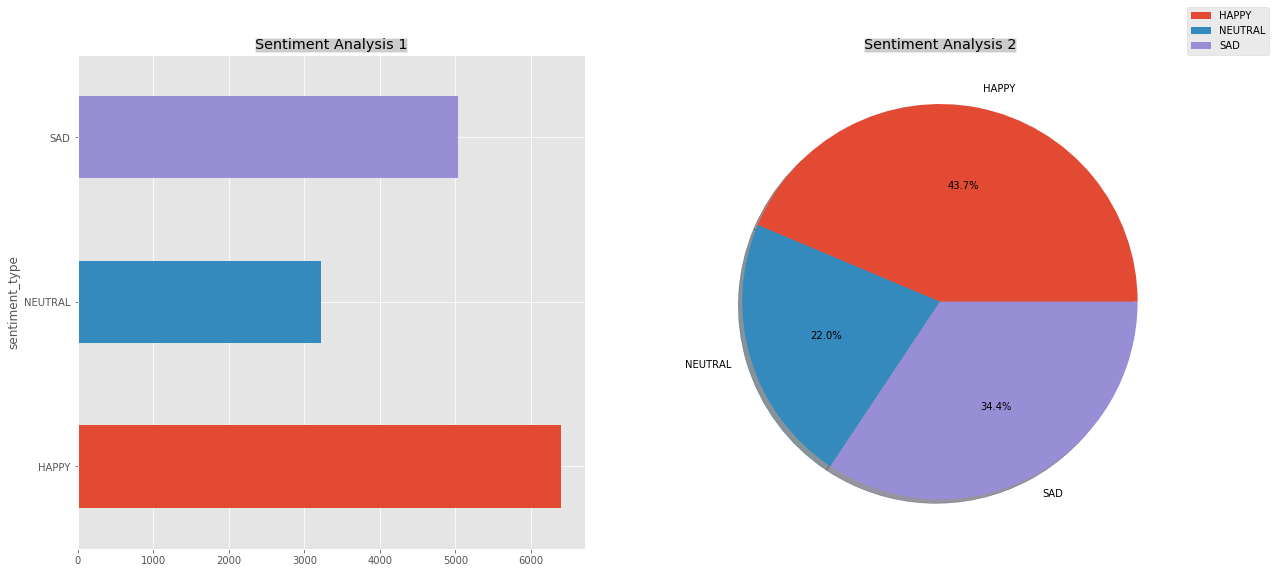

In [0]:
tweets_sentiment = tweets.groupby(['sentiment_type'])['sentiment_neutral'].count()
tweets_sentiment.rename("", inplace = True)
explode = (1, 0, 0)
plt.subplot(221)
tweets_sentiment.transpose().plot(kind = 'barh', figsize=(20, 20))
plt.title('Sentiment Analysis 1', bbox = {'facecolor':'0.8', 'pad':0})
plt.subplot(222)
tweets_sentiment.plot(kind = 'pie', figsize = (20, 20), autopct = '%1.1f%%', shadow = True)
plt.legend(bbox_to_anchor = (1, 1), loc = 3, borderaxespad = 0.)
plt.title('Sentiment Analysis 2', bbox = {'facecolor':'0.8', 'pad':0})
plt.show()

In [0]:
tweets.head()

,text,tweetos,text_lem,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,what said,@VirginAmerica,what said,0.0000,1.000,0.000,0.000,NEUTRAL
1,plus you've added commercials to the experienc...,@VirginAmerica,plus you ve added commercials to the experienc...,0.0000,1.000,0.000,0.000,NEUTRAL
2,i didn't today must mean i need to take anothe...,@VirginAmerica,i didn t today must mean i need to take anothe...,0.0000,1.000,0.000,0.000,NEUTRAL
3,"it's really aggressive to blast obnoxious ""ent...",@VirginAmerica,it s really aggressive to blast obnoxious ent...,-0.2716,0.628,0.236,0.135,SAD
4,and it's a really big bad thing about it,@VirginAmerica,and it s a really big bad thing about it,-0.5829,0.649,0.351,0.000,SAD


### Word Count

In [0]:
tweets['word_count'] = tweets['text_lem'].str.split().str.len()
tweets.head()

,text,tweetos,text_lem,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type,word_count
0,what said,@VirginAmerica,what said,0.0000,1.000,0.000,0.000,NEUTRAL,2
1,plus you've added commercials to the experienc...,@VirginAmerica,plus you ve added commercials to the experienc...,0.0000,1.000,0.000,0.000,NEUTRAL,9
2,i didn't today must mean i need to take anothe...,@VirginAmerica,i didn t today must mean i need to take anothe...,0.0000,1.000,0.000,0.000,NEUTRAL,12
3,"it's really aggressive to blast obnoxious ""ent...",@VirginAmerica,it s really aggressive to blast obnoxious ent...,-0.2716,0.628,0.236,0.135,SAD,17
4,and it's a really big bad thing about it,@VirginAmerica,and it s a really big bad thing about it,-0.5829,0.649,0.351,0.000,SAD,10


### bigrams

In [0]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

In [0]:
tweets['bigrams'] = tweets['text_lem'].map(lambda x: find_ngrams(x.split(" "), 2))

In [0]:
tweets.head()

,text,tweetos,text_lem,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type,word_count,bigrams
0,what said,@VirginAmerica,what said,0.0000,1.000,0.000,0.000,NEUTRAL,2,"[(what, said)]"
1,plus you've added commercials to the experienc...,@VirginAmerica,plus you ve added commercials to the experienc...,0.0000,1.000,0.000,0.000,NEUTRAL,9,"[(plus, you), (you, ve), (ve, added), (added, ..."
2,i didn't today must mean i need to take anothe...,@VirginAmerica,i didn t today must mean i need to take anothe...,0.0000,1.000,0.000,0.000,NEUTRAL,12,"[(i, didn), (didn, t), (t, today), (today, mus..."
3,"it's really aggressive to blast obnoxious ""ent...",@VirginAmerica,it s really aggressive to blast obnoxious ent...,-0.2716,0.628,0.236,0.135,SAD,17,"[(it, s), (s, really), (really, aggressive), (..."
4,and it's a really big bad thing about it,@VirginAmerica,and it s a really big bad thing about it,-0.5829,0.649,0.351,0.000,SAD,10,"[(and, it), (it, s), (s, a), (a, really), (rea..."


In [0]:
tweets_ = pd.read_csv('AirWays_Sentiment_Analysis.csv')

In [0]:
tweets_.columns

Index(['tweet_id', 'airline_sentiment_confidence', 'airline', 'name', 'text',
       'tweet_created', 'tweet_location', 'user_timezone',
       'airline_sentiment'],
      dtype='object')

In [0]:
tweets_.head()

,tweet_id,airline_sentiment_confidence,airline,name,text,tweet_created,tweet_location,user_timezone,airline_sentiment
0,5.703061e+17,1.0000,Virgin America,cairdin,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),NaN
1,5.703011e+17,0.3486,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),NaN
2,5.703011e+17,0.6837,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),NaN
3,5.703010e+17,1.0000,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),NaN
4,5.703008e+17,1.0000,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),NaN


In [0]:
tweets_['asc'] =  